# Model evaluation

This notebook will:
* Look closer on the data and predictions

This notebook assumes:
* The labels of the dataset is in the rightmost column
* One of the other columns contain journey number

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pds
import matplotlib.pyplot as plt

Pick the name for your model, this string is also used to handle special cases of certain models, so stick to naming convention!

In [2]:
model_name = 'ANN_M1'

In [3]:
def mae(preds, labels):
    acc = 0 
    n = len(preds)
    for i in range(n):
        e = abs(preds[i] - labels[i])
        acc += e

    acc /= n
    return acc

def mape(preds, labels):
    acc = 0
    n = len(preds)
    for i in range(n):
        acc+=abs((labels[i] - preds[i])/labels[i])
    
    res = acc/n
    return res

## Load model and data

In [4]:
data = pds.read_pickle(model_name + '.pkl')
data.head()

,seg,journey,speed,pred,label
0,1,2,0.0,185.35202,191.0
1,1,2,0.0,184.35202,190.0
2,1,2,0.0,183.35202,189.0
3,1,2,0.0,182.35202,188.0
4,1,2,0.0,181.35202,187.0


## Start by looking at an entire journey

In [5]:
journeys = data.journey.unique()

Pick out a random journey

In [6]:
selected_journey = np.random.choice(journeys)
one_journey = data[data['journey'] == selected_journey]

### First plot

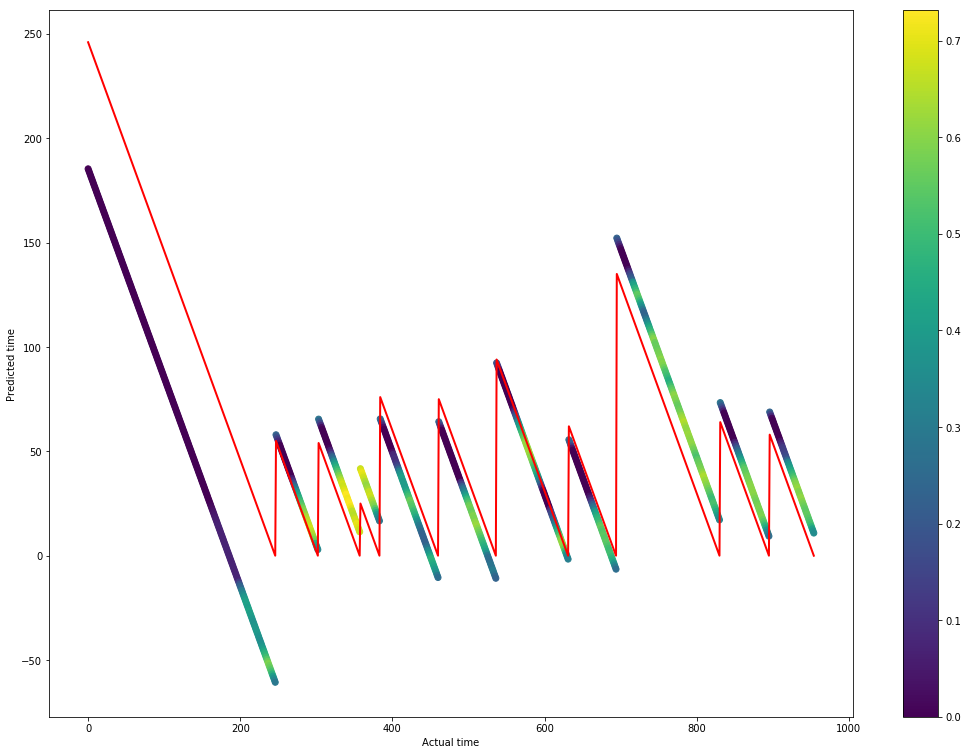

Losse for this journey: 
MAE = 23.01333402463903 s


In [7]:
plt.rcParams['figure.figsize'] = [18, 13]
plt.ylabel('Predicted time')
plt.xlabel('Actual time')

plt.plot(one_journey.label.values, color='red', linewidth=2, markersize=12)
plt.scatter(range(len(one_journey.pred)), one_journey.pred, c=one_journey.speed.values)
plt.colorbar()

plt.show()
print('Losse for this journey:',
      '\nMAE =', mae(one_journey.pred.values, one_journey.label.values), 's')

Note that the plot above contains all 11 segments. The first segment has trouble finding a good estimate in the beginning, probably because the bus stays idle on this station (ändhållplatsen) for a long time. This does not seem to apply to model M1 though!

Also, the color is normalized speed (0-1)

### Scatterplot of test data

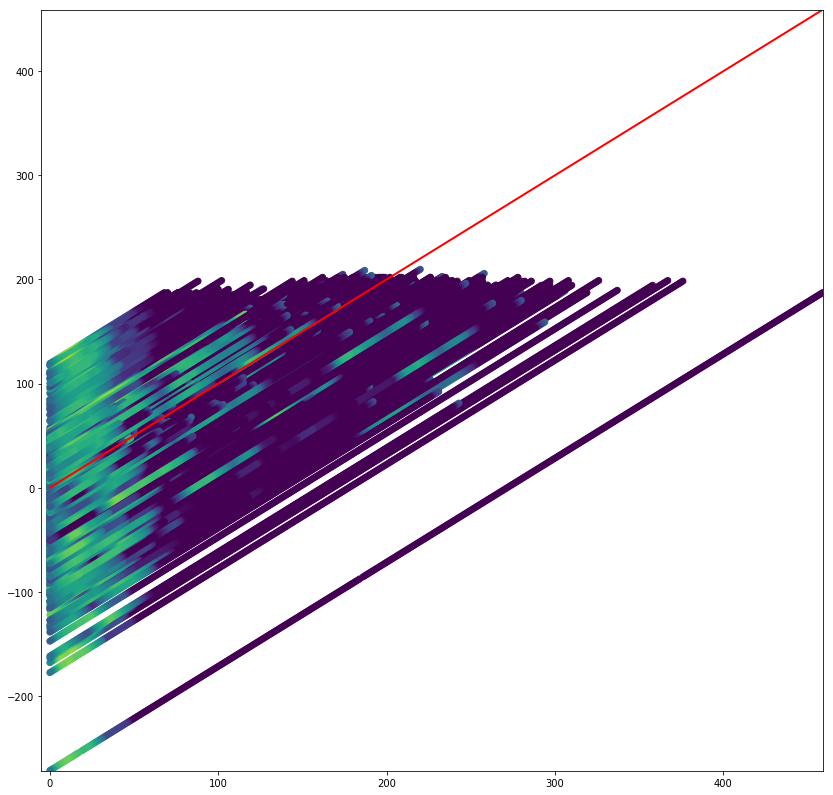

In [8]:
plt.rcParams['figure.figsize'] = [14, 14]
color = data.speed
plt.scatter(data.label, data.pred, c=color)
max_time = np.int_(np.round(np.append(np.transpose(data.label), data.pred).max()))
min_pred = np.int_(np.round(data.pred.values.min()))
plt.xlim(-5, max_time)
plt.ylim(min_pred, max_time)
plt.plot(range(max_time),range(max_time), color='red', linewidth=2)
plt.show()

## Evaluate model on all but the first segment

Create a set that ignores the first segment

In [9]:
# Drop first segment, all journeys
data_wo_first = data[data.seg != 1]

one_journey_wo_first = data_wo_first[data_wo_first.journey == selected_journey]

Evaluate model on all data

In [10]:
mae_all = mae(data.pred.values, data.label.values)
mae_nall = mae(data_wo_first.pred.values, data_wo_first.label.values)
print('Losses for all journeys:',
      '\nMAE =', mae_all, 's')
print('Except segment 1:',
      '\nMAE =', mae_nall, 's')
print('Improvement:', mae_nall/mae_all*100, '%')

Losses for all journeys: 
MAE = 17.09632871379411 s
Except segment 1: 
MAE = 14.733712576182551 s
Improvement: 86.18056439389065 %


In general, alla models benefit from removing the first segment. There is probably a lot of dwell time at the start of the segment.

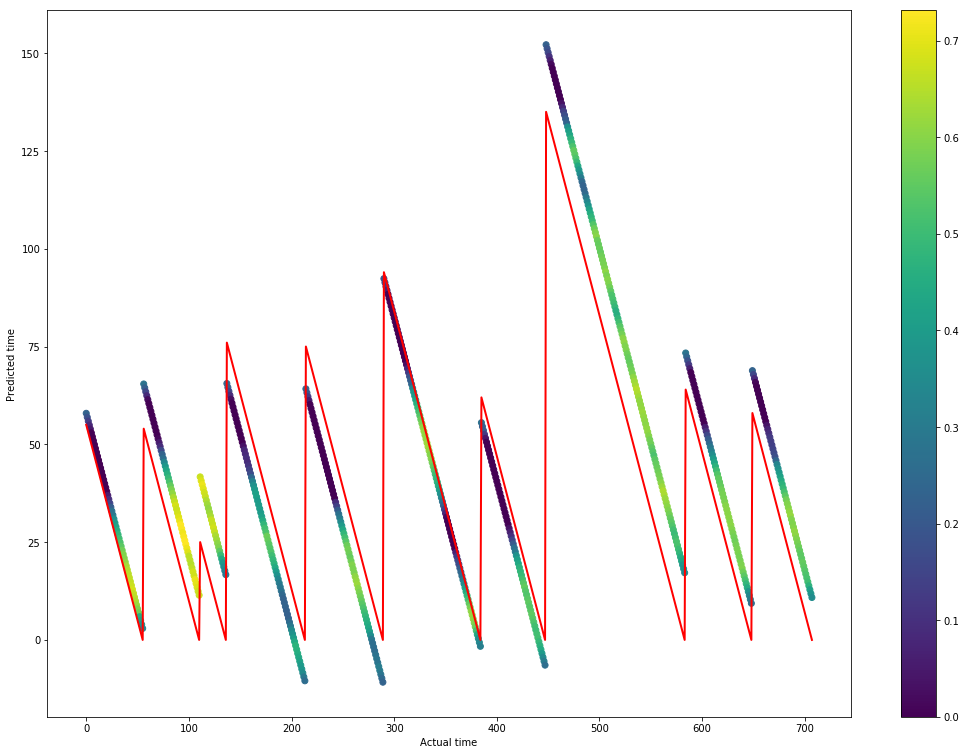

Loss for this journey: 
MAE = 9.883733048950885 s


In [11]:
plt.rcParams['figure.figsize'] = [18, 13]
plt.plot(one_journey_wo_first.label.values, color='red', linewidth=2, markersize=12)
plt.scatter(range(len(one_journey_wo_first.pred)),one_journey_wo_first.pred, c=one_journey_wo_first.speed.values)
plt.colorbar()

plt.ylabel('Predicted time')
plt.xlabel('Actual time')
plt.show()
print('Loss for this journey:',
      '\nMAE =', mae(one_journey_wo_first.pred.values, one_journey_wo_first.label.values), 's')

## Now, lets look only at segment 9 (McD to Gamla Linköping for line 3)

In [12]:
# Select segment 9 for all journeys
data_9 = data[data.seg == 9]

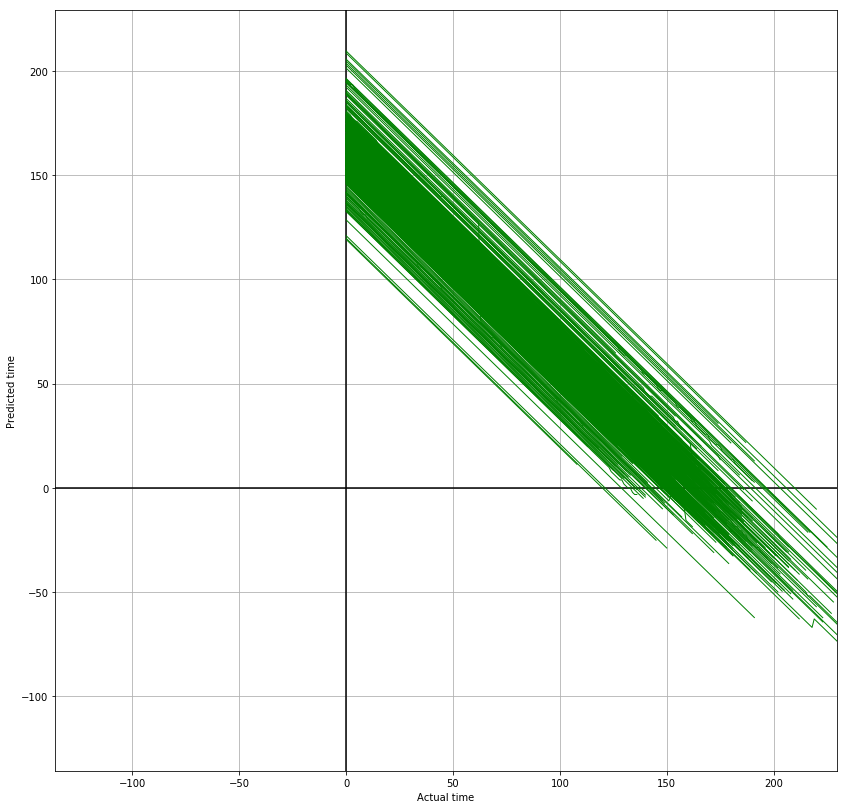

In [13]:
plt.rcParams['figure.figsize'] = [14, 14]
plt.xlim(min_pred/2, max_time/2)
plt.ylim(min_pred/2, max_time/2)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True)
plt.ylabel('Predicted time')
plt.xlabel('Actual time')

for i, j in data_9.groupby('journey'):
    #plt.plot(j.label.values, color='red', linewidth=1, markersize=2)
    plt.plot(j.pred.values, color='green', linewidth=1, markersize=2)

plt.show()

For bus line 3:

There seems to be large variance in this segment. This is the segment containing Vallarondellen, which is known for having large traffic issues during rush hours. This is probably why some journeys are very far to the right and the actual travel time ranges from 100-350 seconds.

## Running the data through a filter

In [14]:
import kalman_filter as kf

data['pred_kalman'] = np.zeros(len(data))

for j, jour in data.groupby('journey'):
    for s, seg in jour.groupby('seg'):
        sigma_0 = seg.iloc[0].pred + seg.iloc[0].pred/2
        R = 1
        Q = 10
        data.loc[seg.index, ('pred_kalman')] = kf.kalman_filter(seg.pred.values, sigma_0, R, Q)[0]

In [15]:
print('Losses:\nFiltered:', mae(data.pred_kalman, data.label), '\nUnfiltered:', mae_all)

Losses:
Filtered: 17.09299914992296 
Unfiltered: 17.09632871379411


In [16]:
one_journey_kf = data[data['journey'] == selected_journey]

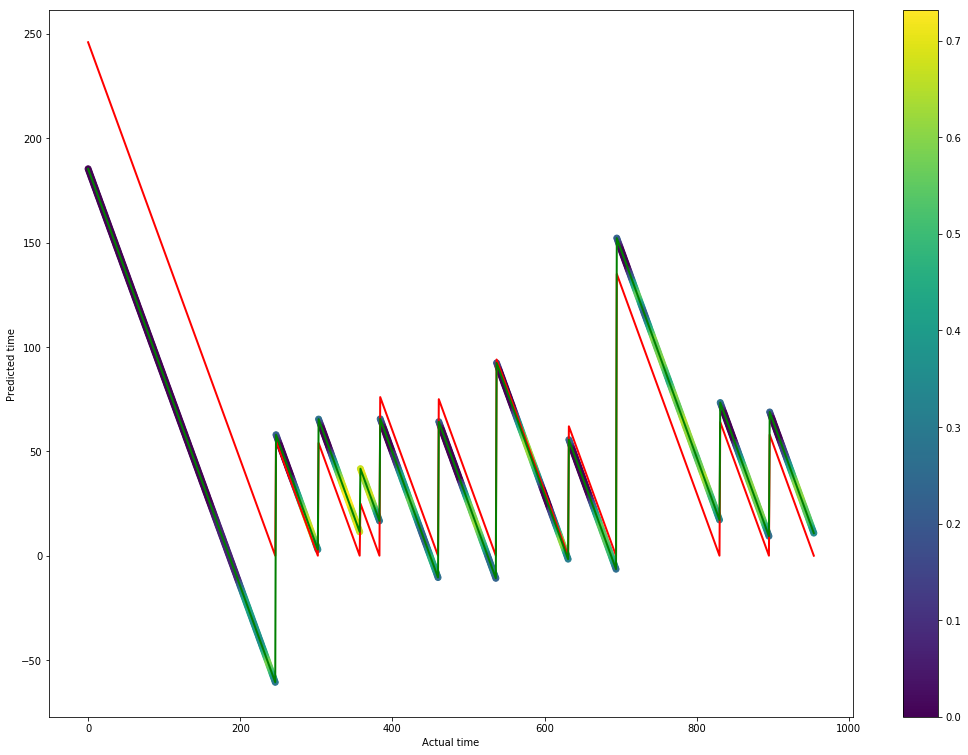

Losse for this journey: 
KF MAE = 23.01333402463903 s
UF MAE = 23.01333402463903 s


In [17]:
plt.rcParams['figure.figsize'] = [18, 13]
plt.ylabel('Predicted time')
plt.xlabel('Actual time')

plt.plot(one_journey_kf.label.values, color='red', linewidth=2, markersize=12)
plt.scatter(range(len(one_journey_kf.pred)), one_journey_kf.pred, c=one_journey_kf.speed.values)
plt.plot(one_journey_kf.pred_kalman.values, color='green', linewidth=2, markersize=12)
plt.colorbar()

plt.show()
print('Losse for this journey:',
      '\nKF MAE =', mae(one_journey_kf.pred_kalman.values, one_journey_kf.label.values), 's\nUF MAE =',
     mae(one_journey_kf.pred.values, one_journey_kf.label.values), 's')

This oftenmost looks like it worsen the results